# RNN 만들기.. 파이토치 삽질 일주일 차
#### 되게 해 주십쇼
# 아멘

#

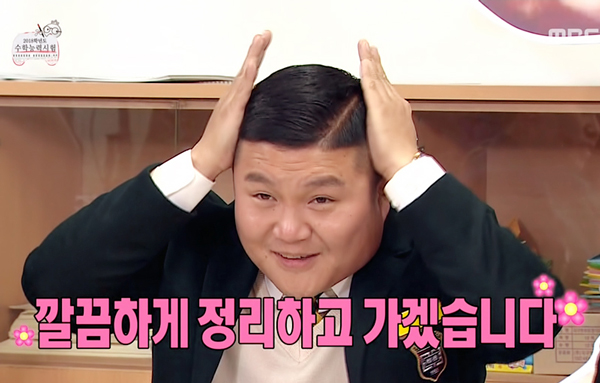

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
!pip install import_ipynb
import import_ipynb
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot
import tensorflow as tf

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=e83f33ca25f250232598883cf27a9661919a8f39fb8608f89777b3621a3ba852
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install import_ipynb
import import_ipynb

In [4]:
!cp /content/drive/MyDrive/Jupyter/unlimited_power/합치기_전_임시작업/MJ/rg_defs2.ipynb .
import rg_defs2 as RG

importing Jupyter notebook from rg_defs2.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_use = ['Time', 'DHI','DNI','RH','T','TARGET']

n_features = len(what_to_use)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [6]:
# 데이터 불러오기 

raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/sample_submission.csv')
submission.shape

(7776, 10)

In [7]:
# drop_clms 함수를 이용하여 쓰지 않는 데이터 분리하기

dataset = RG.drop_clms(raw_data)

# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()
# X2 = dataset.iloc[:,:-1]
# y2 = dataset.iloc[:,-1:]
# fitted_X2 = scaler_X.fit(X2)
# fitted_y2 = scaler_y.fit(y2)


# scaled_X2 = pd.DataFrame(scaler_X.transform(X2), columns=X2.columns, index = X2.index)
# scaled_y2 = pd.DataFrame(scaler_y.transform(y2), columns=y2.columns, index = X2.index)
# dataset2 = pd.concat([scaled_X2, scaled_y2], axis = 1)
# dataset2

In [8]:
scaler = MinMaxScaler()

train = dataset.copy()
test = dataset['TARGET'].copy()

fitted = scaler.fit(train)
dataset2 = pd.DataFrame(scaler.transform(train), columns=dataset.columns, index = dataset.index)

dataset2

,Time,DHI,DNI,RH,T,TARGET
0,0.000000,0.0,0.0,0.665404,0.129630,0.0
1,0.021277,0.0,0.0,0.665188,0.129630,0.0
2,0.042553,0.0,0.0,0.694622,0.129630,0.0
3,0.063830,0.0,0.0,0.694297,0.129630,0.0
4,0.085106,0.0,0.0,0.731631,0.129630,0.0
...,...,...,...,...,...,...
52555,0.914894,0.0,0.0,0.682935,0.277778,0.0
52556,0.936170,0.0,0.0,0.640623,0.277778,0.0
52557,0.957447,0.0,0.0,0.640515,0.277778,0.0
52558,0.978723,0.0,0.0,0.650687,0.277778,0.0


In [9]:
pd.DataFrame(test, index = train.index)

,TARGET
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
52555,0.0
52556,0.0
52557,0.0
52558,0.0


In [11]:
dataset3 = RG.scale_to_supervised(dataset2, test, n_days)
dataset3

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.000000,0.0,0.0,0.665404,0.129630,0.0,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,...,0.129630,0.0,0.893617,0.0,0.0,0.814955,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.0,0.0
145,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,...,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.0,0.0
146,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,...,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.0,0.0
147,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,...,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.0,0.0
148,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,0.148148,0.0,0.212766,0.0,0.0,0.715832,...,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.063830,0.0,0.0,0.692349,0.111111,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,0.914894,0.0,0.0,0.836057,0.203704,0.0,0.936170,0.0,0.0,0.808029,0.203704,0.0,0.957447,0.0,0.0,0.807921,0.203704,0.0,0.978723,0.0,0.0,0.795910,0.203704,0.0,1.

In [12]:
# train_X, train_y, test_X, test_y로 분리하는 함수.

X_train_1, X_valid_1, Y_train_1,  Y_valid_1, X_train_2, X_valid_2, Y_train_2, Y_valid_2 = RG.seperator(dataset3)

In [13]:
### min_max_scale이나 normalize 하는 경우


df_test = []

for i in range(81):
    file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    testset = RG.drop_clms(temp)
    X = testset.copy()
    y = testset.iloc[:,-1:]
    # scaled_X = pd.DataFrame(scaler_X.transform(X), columns=X.columns, index = X.index)
    # scaled_y = pd.DataFrame(scaler_y.transform(y), columns=y.columns, index = X.index)
    # testset2 = pd.concat([scaled_X, scaled_y], axis = 1)
    scaled_X = pd.DataFrame(scaler.transform(X), index = X.index, columns=X.columns)
    testset3 = RG.scale_to_supervised(scaled_X, y, n_days, dropnan=False)   
    testset4 = testset3.iloc[-ticks:, :]
    df_test.append(testset4)

X_test = pd.concat(df_test)
X_test = X_test.iloc[:, :n_obs]
X_test.shape

(3888, 864)

In [14]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [15]:
X_train_1

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
1555,0.404255,0.301136,0.112370,0.595282,0.444444,0.189726,0.425532,0.361742,0.127479,0.558381,0.462963,0.232928,0.446809,0.397727,0.072710,0.558056,0.462963,0.231049,0.468085,0.179924,0.000000,0.564225,0.462963,0.089226,0.489362,0.482955,0.140699,0.563792,0.462963,0.313701,0.510638,0.412879,0.028329,0.568986,0.462963,0.219779,0.531915,0.473485,0.071766,0.568661,...,0.000000,0.653934,0.314815,0.000000,0.276596,0.000000,0.000000,0.601234,0.333333,0.000000,0.297872,0.000000,0.000000,0.619738,0.333333,0.000000,0.319149,0.028409,0.000000,0.523753,0.351852,0.014089,0.340426,0.092803,0.000000,0.536414,0.370370,0.046025,0.361702,0.066288,0.000000,0.536522,0.388889,0.032874,0.382979,0.142045,0.000000,0.496808,0.407407,0.070444
38121,0.191489,0.000000,0.000000,0.543339,0.296296,0.000000,0.212766,0.000000,0.000000,0.529380,0.296296,0.000000,0.234043,0.000000,0.000000,0.529272,0.296296,0.000000,0.255319,0.000000,0.000000,0.518883,0.296296,0.000000,0.276596,0.000000,0.000000,0.435234,0.333333,0.000000,0.297872,0.053030,0.366383,0.434585,0.351852,0.056357,0.319149,0.081439,0.592068,0.398009,...,0.000000,0.554810,0.407407,0.000000,0.063830,0.000000,0.000000,0.601666,0.407407,0.000000,0.085106,0.000000,0.000000,0.568012,0.407407,0.000000,0.106383,0.000000,0.000000,0.616059,0.388889,0.000000,0.127660,0.000000,0.000000,0.572557,0.388889,0.000000,0.148936,0.000000,0.000000,0.572341,0.370370,0.000000,0.170213,0.000000,0.000000,0.551564,0.370370,0.000000
4783,0.659574,0.251894,0.672332,0.114273,0.648148,0.492100,0.680851,0.253788,0.550519,0.118277,0.648148,0.382223,0.702128,0.104167,0.763928,0.131696,0.611111,0.339030,0.723404,0.094697,0.661945,0.247376,0.592593,0.234788,0.744681,0.126894,0.207743,0.320203,0.537037,0.101432,0.765957,0.062500,0.238905,0.411103,0.500000,0.051656,0.787234,0.000000,0.000000,0.484255,...,0.892351,0.132020,0.629630,0.881845,0.531915,0.251894,0.889518,0.131912,0.629630,0.873393,0.553191,0.829545,0.131256,0.138946,0.629630,0.519340,0.574468,0.645833,0.033050,0.153771,0.629630,0.347479,0.595745,0.291667,0.007554,0.167190,0.629630,0.150261,0.617021,0.178030,0.000000,0.184071,0.611111,0.088279,0.638298,0.420455,0.016997,0.208094,0.592593,0.219762
20757,0.446809,0.340909,0.664778,0.312520,0.611111,0.587903,0.468085,0.613636,0.301228,0.286116,0.629630,0.505253,0.489362,0.662879,0.255902,0.285900,0.629630,0.506192,0.510638,0.570076,0.428706,0.285900,0.648148,0.585073,0.531915,0.693182,0.148253,0.310356,0.629630,0.447966,0.553191,0.653409,0.089707,0.311546,0.629630,0.386923,0.574468,0.195076,0.000000,0.338059,...,0.475921,0.451791,0.351852,0.085475,0.319149,0.089015,0.651558,0.414457,0.388889,0.182218,0.340426,0.109848,0.746931,0.322043,0.425926,0.280835,0.361702,0.125000,0.813031,0.294340,0.444444,0.378512,0.382979,0.140152,0.850803,0.224867,0.462963,0.467734,0.404255,0.149621,0.881964,0.224759,0.481481,0.548501,0.425532,0.164773,0.895184,0.204307,0.500000,0.616118
47626,0.212766,0.000000,0.000000,0.951304,0.462963,0.000000,0.234043,0.000000,0.000000,0.881615,0.481481,0.000000,0.255319,0.039773,0.000000,0.818743,0.500000,0.019723,0.276596,0.081439,0.376771,0.

In [16]:
def to_tensor(X): #,y, batch = 400):
  X = X.values.reshape(X.values.shape[0], 1, -1)
  # y = y.values.reshape(y.values.shape[0],1) #,-1)
  # tensor_X = torch.from_numpy(X)
  # tensor_y = torch.from_numpy(y)
  # tensor_set = TensorDataset(tensor_X, tensor_y)
  # results = DataLoader(tensor_set, batch_size = batch, shuffle=True)
  return X

In [17]:
# train_X1, train_y1 = to_tensor(X_train_1, Y_train_1)
# valid_X1, valid_y1 = to_tensor(X_valid_1, Y_valid_1)
# train_X2, train_y2 = to_tensor(X_train_2, Y_train_2)
# valid_X2, valid_y2 = to_tensor(X_valid_2, Y_valid_2)

In [18]:
# test_X = X_test.values.reshape(X_test.values.shape[0], n_days, -1)
X_test.shape

(3888, 864)

In [19]:
X_train_1 = to_tensor(X_train_1)
X_valid_1 = to_tensor(X_valid_1)
X_train_2 = to_tensor(X_train_2)
X_valid_2 = to_tensor(X_valid_2)
X_test = to_tensor(X_test)

In [20]:
from tensorflow.keras.backend import mean, maximum

def quantile_loss(q, y, pred):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [22]:
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [25]:
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LSTM_actual_pred = pd.DataFrame()

    for q in quantiles:
      model = Sequential()
      model.add(LSTM(144, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
      model.add(Dropout(0.3))
      model.add(Dense(128))
      model.add(Dense(64))
      model.add(Dense(32))
      model.add(Dense(10))
      model.add(Dense(1, activation='linear'))
      model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
      # model.compile(loss='mae', optimizer='adam')
      # fit network
      history = model.fit(X_train, Y_train, epochs=1000, batch_size=200, validation_data=(X_valid, Y_valid), verbose=2, shuffle=True, callbacks=[es, mc])
      print(q)
      pred = model.predict(X_test)
      pred = pred.reshape(pred.shape[0],1)
      # pred = scaler_y.inverse_transform(pred)
      pred = pd.DataFrame(pred)
      LSTM_actual_pred = pd.concat([LSTM_actual_pred,pred],axis=1)
        
    LSTM_actual_pred.columns=quantiles
    
    return LSTM_actual_pred

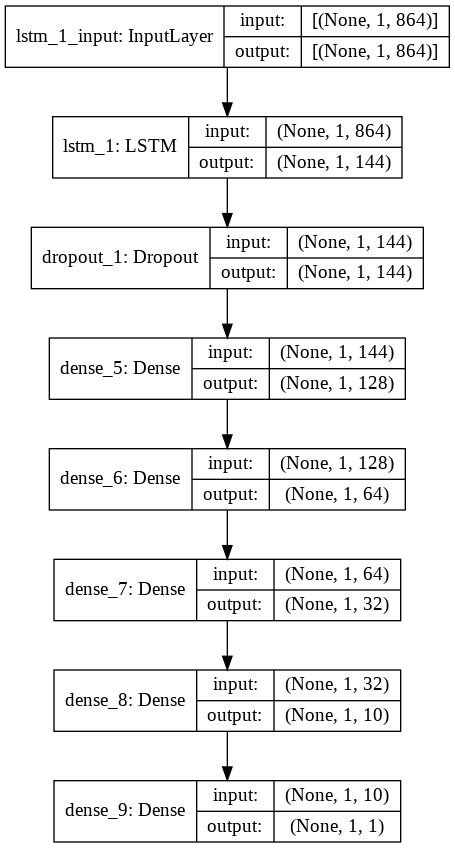

In [24]:
model = Sequential()
model.add(LSTM(144, input_shape=(X_train_1.shape[1], X_train_1.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(10))
model.add(Dense(1, activation='linear'))

keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

In [26]:
results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)

Streaming output truncated to the last 5000 lines.
184/184 - 1s - loss: 2.1656 - val_loss: 2.4803
Epoch 144/1000
184/184 - 1s - loss: 2.2017 - val_loss: 2.4690
Epoch 145/1000
184/184 - 1s - loss: 2.1759 - val_loss: 2.4717
Epoch 146/1000
184/184 - 1s - loss: 2.1759 - val_loss: 2.5720
Epoch 147/1000
184/184 - 1s - loss: 2.1835 - val_loss: 2.4560
Epoch 148/1000
184/184 - 1s - loss: 2.1579 - val_loss: 2.4765
Epoch 149/1000
184/184 - 1s - loss: 2.1827 - val_loss: 2.5148
Epoch 150/1000
184/184 - 1s - loss: 2.1630 - val_loss: 2.4835
Epoch 151/1000
184/184 - 1s - loss: 2.1795 - val_loss: 2.4439
Epoch 152/1000
184/184 - 1s - loss: 2.1612 - val_loss: 2.4441
Epoch 153/1000
184/184 - 1s - loss: 2.1606 - val_loss: 2.4413
Epoch 154/1000
184/184 - 1s - loss: 2.1523 - val_loss: 2.4585
Epoch 155/1000
184/184 - 1s - loss: 2.1625 - val_loss: 2.4547
Epoch 156/1000
184/184 - 1s - loss: 2.1509 - val_loss: 2.5708
Epoch 157/1000
184/184 - 1s - loss: 2.1546 - val_loss: 2.4365
Epoch 158/1000
184/184 - 1s - loss

In [27]:
results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)

Streaming output truncated to the last 5000 lines.
184/184 - 1s - loss: 2.5899 - val_loss: 2.6526
Epoch 70/1000
184/184 - 1s - loss: 2.5570 - val_loss: 2.6313
Epoch 71/1000
184/184 - 1s - loss: 2.5366 - val_loss: 2.7167
Epoch 72/1000
184/184 - 1s - loss: 2.5448 - val_loss: 2.7866
Epoch 73/1000
184/184 - 1s - loss: 2.5382 - val_loss: 2.6725
Epoch 74/1000
184/184 - 1s - loss: 2.5344 - val_loss: 2.6770
Epoch 75/1000
184/184 - 1s - loss: 2.5122 - val_loss: 2.6921
Epoch 76/1000
184/184 - 1s - loss: 2.5106 - val_loss: 2.6533
Epoch 77/1000
184/184 - 1s - loss: 2.5054 - val_loss: 2.6693
Epoch 78/1000
184/184 - 1s - loss: 2.4956 - val_loss: 2.6467
Epoch 79/1000
184/184 - 1s - loss: 2.5059 - val_loss: 2.6463
Epoch 80/1000
184/184 - 1s - loss: 2.4843 - val_loss: 2.6306
Epoch 81/1000
184/184 - 1s - loss: 2.4983 - val_loss: 2.6275
Epoch 82/1000
184/184 - 1s - loss: 2.5030 - val_loss: 2.6209
Epoch 83/1000
184/184 - 1s - loss: 2.4804 - val_loss: 2.6880
Epoch 84/1000
184/184 - 1s - loss: 2.4964 - val_

In [28]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission2 = submission.set_index('id')
submission2

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,-0.013779,-0.011551,-0.004020,0.003315,-0.002871,-0.002315,0.002616,0.001367,0.001651
0.csv_Day7_0h30m,-0.013946,-0.011888,-0.004128,0.004334,-0.002880,-0.001327,0.002656,-0.000695,0.001631
0.csv_Day7_1h00m,-0.014032,-0.012008,-0.004124,0.002892,-0.002889,-0.001256,0.002735,-0.001099,0.001730
0.csv_Day7_1h30m,-0.014060,-0.012056,-0.004104,0.002883,-0.002884,-0.001018,0.002819,-0.001387,0.001833
0.csv_Day7_2h00m,-0.014019,-0.012001,-0.004011,0.002639,-0.002893,0.001027,0.002867,-0.001416,0.002043
...,...,...,...,...,...,...,...,...,...
80.csv_Day8_21h30m,-0.058845,0.002932,-0.007514,-0.005051,0.004196,0.001086,-0.000544,0.000354,0.002869
80.csv_Day8_22h00m,-0.058829,0.002910,-0.007646,-0.005387,0.003841,0.001189,0.000031,0.000377,0.002582
80.csv_Day8_22h30m,-0.058717,0.002915,-0.007628,-0.005434,0.003887,0.001088,-0.000639,0.000313,0.002544


In [29]:
def not_minus(dataset):
  for i in range(0, len(dataset.index)):
    for j in range(0, len(dataset.columns)):
      K = dataset.iloc[i,j]
      if K < 0:
        dataset.iloc[i,j] = 0
  return dataset

In [30]:
submission3 = not_minus(submission2)

In [31]:
submission3

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.000000,0.0,0.003315,0.000000,0.000000,0.002616,0.001367,0.001651
0.csv_Day7_0h30m,0.0,0.000000,0.0,0.004334,0.000000,0.000000,0.002656,0.000000,0.001631
0.csv_Day7_1h00m,0.0,0.000000,0.0,0.002892,0.000000,0.000000,0.002735,0.000000,0.001730
0.csv_Day7_1h30m,0.0,0.000000,0.0,0.002883,0.000000,0.000000,0.002819,0.000000,0.001833
0.csv_Day7_2h00m,0.0,0.000000,0.0,0.002639,0.000000,0.001027,0.002867,0.000000,0.002043
...,...,...,...,...,...,...,...,...,...
80.csv_Day8_21h30m,0.0,0.002932,0.0,0.000000,0.004196,0.001086,0.000000,0.000354,0.002869
80.csv_Day8_22h00m,0.0,0.002910,0.0,0.000000,0.003841,0.001189,0.000031,0.000377,0.002582
80.csv_Day8_22h30m,0.0,0.002915,0.0,0.000000,0.003887,0.001088,0.000000,0.000313,0.002544


In [32]:
submission3.to_csv('submission5.csv')
!cp submission5.csv "drive/My Drive/"